In [1]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [17]:
import numpy as np
import pandas as pd
import datetime as dt
from scipy import stats

# Reflect Tables into SQLAlchemy ORM

In [3]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, inspect, func

In [6]:
# create engine to hawaii.sqlite
engine = create_engine("sqlite:///../Resources/hawaii.sqlite")

In [7]:
# reflect an existing database into a new model
Base= automap_base()

# reflect the tables
Base.prepare(autoload_with=engine)

In [8]:
# View all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [9]:
# Save references to each table
Measurement = Base.classes.measurement
Station = Base.classes.station

In [8]:
#Determine the columns in the measurement table
inspector=inspect(engine)
columns=inspector.get_columns('measurement')
for c in columns:
    print(c['name'], c["type"])

id INTEGER
station TEXT
date TEXT
prcp FLOAT
tobs FLOAT


In [9]:
#Determine the columns in the station table
inspector=inspect(engine)
columns=inspector.get_columns('station')
for c in columns:
    print(c['name'], c["type"])

id INTEGER
station TEXT
name TEXT
latitude FLOAT
longitude FLOAT
elevation FLOAT


In [10]:
# Create our session (link) from Python to the DB
session=Session(bind=engine)

# Exploratory Precipitation Analysis

In [11]:
# Find the most recent date in the data set.
recent_date=session.query(Measurement.date).order_by(Measurement.date.desc()).first()

recent_date

('2017-08-23',)

In [12]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results. 
# Starting from the most recent data point in the database. 

# Calculate the date one year from the last date in data set.
year_ago=dt.date(2017, 8, 23)-dt.timedelta(days=365)

year_ago

datetime.date(2016, 8, 23)

In [13]:
# Perform a query to retrieve the data and precipitation scores
precipitation_data=session.query(Measurement.date, Measurement.prcp).\
                    filter(Measurement.date > year_ago)

In [38]:
# Save the query results as a Pandas DataFrame. Explicitly set the column names
df=pd.DataFrame(precipitation_data, columns=['date','prcp'])
df=df.rename(columns={"prcp":"precipitation"})
df

,date,precipitation
0,2016-08-24,0.08
1,2016-08-25,0.08
2,2016-08-26,0.00
3,2016-08-27,0.00
4,2016-08-28,0.01
...,...,...
2218,2017-08-19,0.09
2219,2017-08-20,NaN
2220,2017-08-21,0.56
2221,2017-08-22,0.50


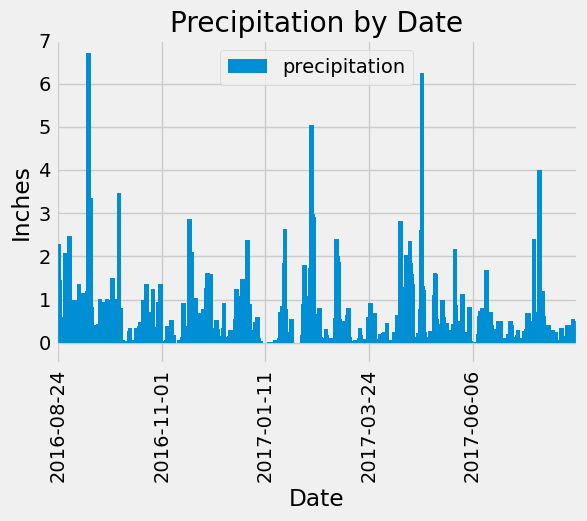

In [45]:
# Sort the dataframe by date
sorted_df=df.sort_values("date",ascending=True)
sorted_df.set_index('date', inplace=True)

# Use Pandas Plotting with Matplotlib to plot the data
sorted_df.plot(kind="bar",
                        figsize=(6,4),
                        title="Precipitation by Date",
                        xlabel="Date",
                        ylabel="Inches",
                        grid=True,
                        width=20,
                        )
plt.ylim(-.5,7)
plt.locator_params(axis='x', nbins=5)
plt.xticks(rotation=90)



plt.show()

#I used the following sources to help with formatting my plot
#https://stackoverflow.com/questions/6682784/reducing-number-of-plot-ticks/49714879#49714879

In [26]:
# Use Pandas to calculate the summary statistics for the precipitation data
sorted_df.describe()

,precipitation
count,2015.000000
mean,0.176462
std,0.460288
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


# Exploratory Station Analysis

In [27]:
# Design a query to calculate the total number of stations in the dataset
station_count = session.query(Measurement.station).group_by(Measurement.station).count()

station_count

9

In [28]:
# Design a query to find the most active stations (i.e. which stations have the most rows?)
# List the stations and their counts in descending order.
station_data_counts = session.query(Measurement.station, func.count(Measurement.station)).\
              group_by(Measurement.station).\
              order_by(func.count(Measurement.station).desc()).all()

station_data_counts
  

[('USC00519281', 2772),
 ('USC00519397', 2724),
 ('USC00513117', 2709),
 ('USC00519523', 2669),
 ('USC00516128', 2612),
 ('USC00514830', 2202),
 ('USC00511918', 1979),
 ('USC00517948', 1372),
 ('USC00518838', 511)]

In [29]:
# Using the most active station id from the previous query, calculate the lowest, highest, and average temperature.
sel=[func.min(Measurement.tobs),
     func.max(Measurement.tobs),
     func.avg(Measurement.tobs)]

session.query(*sel).\
filter(Measurement.station == 'USC00519281').all()

[(54.0, 85.0, 71.66378066378067)]

In [30]:
# Using the most active station id
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram
station_year=session.query(Measurement.tobs).\
            filter(Measurement.station == 'USC00519281').\
            filter(Measurement.date > year_ago).all()

station_year_df=pd.DataFrame(station_year,columns=['tobs'])

station_year_df

,tobs
0,77.0
1,80.0
2,80.0
3,75.0
4,73.0
...,...
346,77.0
347,77.0
348,76.0
349,76.0


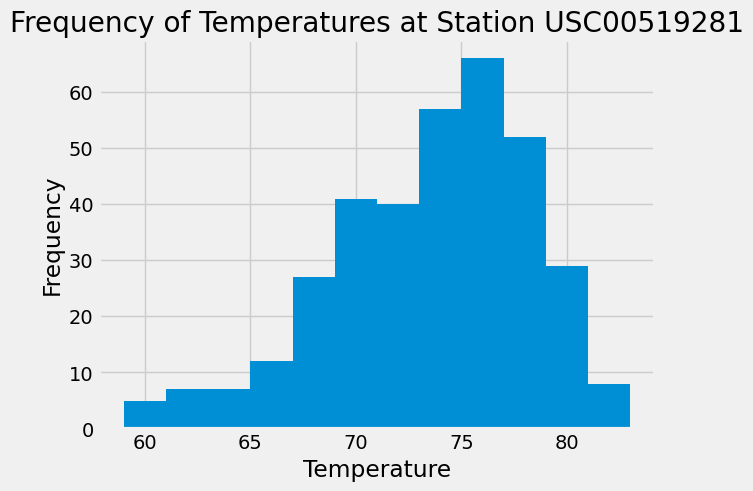

In [32]:
#plot the results as a histogram
plt.hist(station_year_df, bins=12)
plt.title('Frequency of Temperatures at Station USC00519281')
plt.xlabel('Temperature')
plt.ylabel('Frequency')
plt.show()

# Close Session

In [46]:
# Close Session
session.close()

In [26]:
session = Session(bind=engine)

date_format='%Y%m%d'
start='20161123'

# Query based on the start date and close the session
start_date=session.query(Measurement.tobs).\
            filter(Measurement.date >= dt.datetime.strptime(start, date_format)).all()

start_date_dict={}
start_date_dict['min'] = stats.tmin(start_date)
start_date_dict['avg'] = stats.tmean(start_date)
start_date_dict['max'] = stats.tmax(start_date)

start_date_dict

{'min': array([58.]), 'avg': 73.77635588056063, 'max': array([87.])}